In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# updateSavedModel = False

# Read in Data

In [3]:
train_dset = tf.data.experimental.load('../data/dsets_combined_classes/train_dset-128',(tf.TensorSpec(shape=(None, 300, 171), dtype=tf.float64, name=None),
 tf.TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)))
val_dset = tf.data.experimental.load('../data/dsets_combined_classes/val_dset-128',(tf.TensorSpec(shape=(None, 300, 171), dtype=tf.float64, name=None),
 tf.TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)))
test_dset = tf.data.experimental.load('../data/dsets_combined_classes/test_dset-128',(tf.TensorSpec(shape=(None, 300, 171), dtype=tf.float64, name=None),
 tf.TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)))

In [4]:
y_test = np.concatenate([y for x, y in test_dset], axis=0) # for model evaluation
y_test = [np.where(r==1)[0][0] for r in y_test] # convert from one-hot to integer

# Model

combined-0005-128-300-128-0.8-l2reg
learning rate = 0.0005000000237487257
Epoch 1/300
11/11 [==============================] - 5s 445ms/step - loss: 12.9766 - accuracy: 0.1893 - val_loss: 11.9742 - val_accuracy: 0.2118
learning rate = 0.0005000000237487257
Epoch 2/300
11/11 [==============================] - 3s 316ms/step - loss: 11.2525 - accuracy: 0.2025 - val_loss: 10.3843 - val_accuracy: 0.2235
learning rate = 0.0005000000237487257
Epoch 3/300
11/11 [==============================] - 3s 315ms/step - loss: 9.7432 - accuracy: 0.2296 - val_loss: 8.9793 - val_accuracy: 0.2647
learning rate = 0.0005000000237487257
Epoch 4/300
11/11 [==============================] - 3s 315ms/step - loss: 8.4474 - accuracy: 0.2605 - val_loss: 7.8871 - val_accuracy: 0.2235
learning rate = 0.0005000000237487257
Epoch 5/300
11/11 [==============================] - 3s 315ms/step - loss: 7.4019 - accuracy: 0.2649 - val_loss: 6.8791 - val_accuracy: 0.3000
learning rate = 0.0005000000237487257
Epoch 6/300
11/11

learning rate = 0.00020480001694522798
Epoch 46/300
11/11 [==============================] - 3s 315ms/step - loss: 1.8821 - accuracy: 0.4960 - val_loss: 1.9029 - val_accuracy: 0.4765
learning rate = 0.00020480001694522798
Epoch 47/300
11/11 [==============================] - 3s 315ms/step - loss: 1.8949 - accuracy: 0.4850 - val_loss: 1.9160 - val_accuracy: 0.4647
learning rate = 0.00020480001694522798
Epoch 48/300
11/11 [==============================] - 3s 313ms/step - loss: 1.8745 - accuracy: 0.4835 - val_loss: 1.8805 - val_accuracy: 0.5059
learning rate = 0.00020480001694522798
Epoch 49/300
11/11 [==============================] - 3s 316ms/step - loss: 1.8061 - accuracy: 0.5143 - val_loss: 1.8672 - val_accuracy: 0.5176
learning rate = 0.00020480001694522798
Epoch 50/300
11/11 [==============================] - 3s 315ms/step - loss: 1.7805 - accuracy: 0.5143 - val_loss: 1.8568 - val_accuracy: 0.5176
learning rate = 0.00016384001355618238
Epoch 51/300
11/11 [==========================

learning rate = 6.710886955261231e-05
Epoch 91/300
11/11 [==============================] - 3s 315ms/step - loss: 1.3560 - accuracy: 0.6933 - val_loss: 1.5142 - val_accuracy: 0.6294
learning rate = 6.710887100780383e-05
Epoch 92/300
11/11 [==============================] - 3s 314ms/step - loss: 1.3309 - accuracy: 0.7007 - val_loss: 1.4807 - val_accuracy: 0.6235
learning rate = 6.710887100780383e-05
Epoch 93/300
11/11 [==============================] - 3s 316ms/step - loss: 1.3385 - accuracy: 0.7036 - val_loss: 1.5325 - val_accuracy: 0.6294
learning rate = 6.710887100780383e-05
Epoch 94/300
11/11 [==============================] - 3s 315ms/step - loss: 1.3291 - accuracy: 0.7043 - val_loss: 1.5142 - val_accuracy: 0.6412
learning rate = 6.710887100780383e-05
Epoch 95/300
11/11 [==============================] - 3s 313ms/step - loss: 1.3334 - accuracy: 0.6919 - val_loss: 1.5023 - val_accuracy: 0.6529
learning rate = 6.710887100780383e-05
Epoch 96/300
11/11 [==============================] 

11/11 [==============================] - 3s 314ms/step - loss: 1.0891 - accuracy: 0.7909 - val_loss: 1.4161 - val_accuracy: 0.6765
learning rate = 2.7487792976899073e-05
Epoch 136/300
11/11 [==============================] - 3s 313ms/step - loss: 1.0817 - accuracy: 0.7975 - val_loss: 1.3946 - val_accuracy: 0.7000
learning rate = 2.7487792976899073e-05
Epoch 137/300
11/11 [==============================] - 3s 315ms/step - loss: 1.0867 - accuracy: 0.7990 - val_loss: 1.4480 - val_accuracy: 0.6588
learning rate = 2.7487792976899073e-05
Epoch 138/300
11/11 [==============================] - 3s 316ms/step - loss: 1.0784 - accuracy: 0.8026 - val_loss: 1.4060 - val_accuracy: 0.6765
learning rate = 2.7487792976899073e-05
Epoch 139/300
11/11 [==============================] - 3s 315ms/step - loss: 1.0781 - accuracy: 0.7990 - val_loss: 1.4724 - val_accuracy: 0.6588
learning rate = 2.7487792976899073e-05
Epoch 140/300
11/11 [==============================] - 3s 316ms/step - loss: 1.0939 - accuracy

Epoch 00179: early stopping
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../models/model-combined-0005-128-300-128-0.8-l2reg/assets


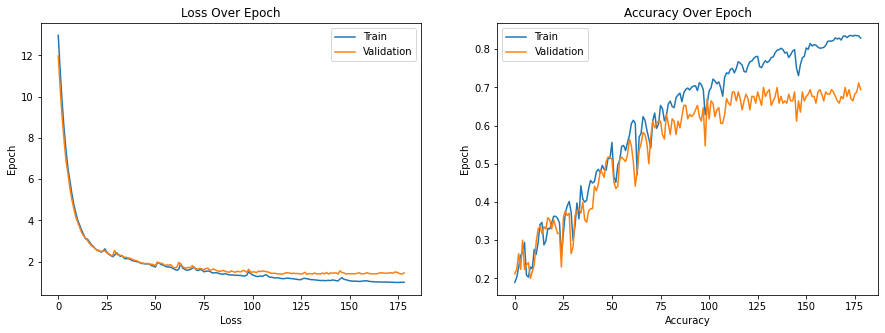

In [7]:
dsets = {}

for batch_size in [128]:
    dsets[f'train-{batch_size}'] = train_dset

    dsets[f'val-{batch_size}'] = val_dset

    dsets[f'test-{batch_size}'] = test_dset

def run_model(hyperparameters):
    lr_str = str(hyperparameters['learning_rate'])[2:]
    hyperparameter_string = f"combined-{lr_str}-{hyperparameters['batch_size']}-{hyperparameters['epochs']}-{hyperparameters['lstm_hidden_units']}-{hyperparameters['decay']}-l2reg"
    print(hyperparameter_string)

    def scheduler(epoch, lr):
        new_lr = lr
        if epoch % 10 == 0 and epoch != 0:
            new_lr = lr * hyperparameters['decay']
        print(f"learning rate = {new_lr}")
        return new_lr

    np.random.seed(0)
    tf.random.set_seed(0)

    num_hidden_units = hyperparameters['lstm_hidden_units']
    num_outputs = 6

    model = tf.keras.Sequential([
            tf.keras.Input(shape=(300, 171)),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(num_hidden_units,return_sequences=True,kernel_regularizer='l2')),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(num_hidden_units,kernel_regularizer='l2')),
            tf.keras.layers.Dense(num_outputs,activation='softmax')
    ])

    opt = tf.keras.optimizers.Adam(learning_rate=hyperparameters['learning_rate'])
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    train_dset = dsets[f"train-{hyperparameters['batch_size']}"]
    val_dset = dsets[f"val-{hyperparameters['batch_size']}"]
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=50, verbose=1)
    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
    history = model.fit(train_dset,epochs=hyperparameters['epochs'],validation_data = val_dset,
                        callbacks=[es, lr_scheduler])
    model.save(f"../models/model-{hyperparameter_string}")

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label="Train")
    plt.plot(history.history['val_loss'], label="Validation")
    plt.title("Loss Over Epoch")
    plt.xlabel("Loss")
    plt.ylabel("Epoch")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label="Train")
    plt.plot(history.history['val_accuracy'], label="Validation")
    plt.title("Accuracy Over Epoch")
    plt.xlabel("Accuracy")
    plt.ylabel("Epoch")
    plt.legend()
    plt.savefig(f"../models/loss-accuracy-{hyperparameter_string}.png")
    plt.show()

    plt.close()
    
    return model

hyperparams = {
    'learning_rate': 0.0005,
    'batch_size': 128,
    'epochs': 300,
    'lstm_hidden_units': 128,
    'decay': 0.8
}

model = run_model(hyperparams)

In [ ]:
# from numpy.random import seed
# from tensorflow.random import set_seed
# seed(0)
# set_seed(0)

# num_hidden_units = 128
# num_outputs = 6

# sequential_model = tf.keras.Sequential()
# sequential_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(num_hidden_units,return_sequences=True)))
# sequential_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(num_hidden_units)))
# sequential_model.add(tf.keras.layers.Dense(num_outputs,activation='softmax'))

# input_layer = tf.keras.Input(shape=(300, 171)) 
# model = tf.keras.Model(inputs=input_layer, outputs=sequential_model(input_layer))

# opt = tf.keras.optimizers.Adam()
# model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

In [ ]:
# es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=50,restore_best_weights=True)

# history = model.fit(train_dset,epochs=100,validation_data = val_dset,callbacks=[es])
# # TODO definitely needs more epochs (see loss curve below)

In [ ]:
# x = np.arange(len(history.history['accuracy']))

# plt.figure(figsize=(15, 5))

# plt.subplot(1, 2, 1)
# plt.plot(history.history['loss'], label="Train")
# plt.plot(history.history['val_loss'], label="Validation")
# plt.title("Loss Over Epoch")
# plt.xlabel("Loss")
# plt.ylabel("Epoch")
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(history.history['accuracy'], label="Train")
# plt.plot(history.history['val_accuracy'], label="Validation")
# plt.title("Accuracy Over Epoch")
# plt.xlabel("Accuracy")
# plt.ylabel("Epoch")
# plt.legend()
# plt.show()

# plt.close()

# # TODO definitely something sketchy with this loss, could be a learning rate thing?

In [ ]:
# test set
(loss,accuracy) = model.evaluate(test_dset)
print('Test accuracy: %.3f' %accuracy)

In [ ]:
# # save model
# if updateSavedModel:
#     model.save("trained-models/model_lstm")

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import cohen_kappa_score
#Note: good source on the methods below: 
#https://towardsdatascience.com/confusion-matrix-for-your-multi-class-machine-learning-model-ff9aa3bf7826
#prelim results

#find model predictions
predictions = model.predict(test_dset)
y_pred = np.argmax(predictions, axis=1) #convert those predictions to labels

#confusion matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test,y_pred, normalize = 'true') #true,pred
display_labels = ['bad_inner_thigh', 'bad_back_warp_or_bad_back_round', 'bad_head', 'bad_shallow', 'bad_toe', 'good']

df_cm = pd.DataFrame(cm, index = display_labels, columns = display_labels)
plt.figure(figsize=(10,7),dpi=300)
#sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True) # font size #,annot_kws={"size": 16}
plt.ylabel('True label', fontweight = 'bold')
plt.xlabel('Predicted label', fontweight = 'bold')
plt.title('Normalized Confusion Matrix', fontweight = 'bold')
plt.show()

#importing accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))


print('\nClassification Report\n')
classification_rep = classification_report(y_test, y_pred, target_names= display_labels)
print(classification_rep)


#Cohen Kappa Statistic
print('Cohen Kappa Statistic\n')
cohen_kappa_score(y_test, y_pred, labels=None, weights=None, sample_weight=None)